# Validation Process - DataAnalyzerPro

#### by: Joan Jaylani

# Table of Contents
- [Dataset Selection and Loading](#dataset-selection-and-loading)
- [Initial Data Profiling](#initial-data-profiling)
- [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
- [ML Task Detection and Setup](#ml-task-detection-and-setup)
- [Determining the Best ML Model for the Dataset](#determining-the-best-ml-model-for-the-dataset)
- [Feature Selection](#feature-selection)
- [Reviewing Results](#reviewing-results)
- [AI-Generated Summary](#ai-generated-summary)


In [1]:
import os
#thread set to 1 to avoid KMeans memory leak warning
os.environ["OMP_NUM_THREADS"] = "4"

import pandas as pd
import ipywidgets as widgets
import seaborn as sns
from ipywidgets import IntSlider, FloatSlider
import shap
import re
import sys
import io
import re
import matplotlib.pyplot as plt 

from IPython.display import display, clear_output,  Markdown
from IPython.display import FileLink, display
import openai
import toml
import os
import re 

import os
import ipywidgets as widgets

from openai import OpenAI

# Load API key from secrets.toml
secrets = toml.load("secrets.toml")
os.environ["OPENAI_API_KEY"] = secrets["openai"]["api_key"]

# Create OpenAI client (reads from env var)
client = OpenAI()

%matplotlib inline

## Dataset Selection and Loading

* First, upload a dataset of your choice. Once a dataset is selected, the notebook will load the data into a pandas DataFrame and perform initial checks:<br>
* File Size Check: If the file is larger than 500 MB, a warning will be shown and the loading may be aborted to avoid memory issues.<br>
* Data Preview: We display the first few rows of the dataset (df.head()) to get a quick glimpse of the data structure.<br>
* Basic Info: We use df.info() and df.shape to show the number of rows, columns, and data types. This helps verify that data types are inferred correctly (e.g., numeric vs. object types).


## AI-Generated Dataset Exploratory Data Analysis
Following the data being uploaded, we run GPT-4.1 generate basic statistics and exploratory data analysis. This gives graphs and preliminary data insights. 

In [5]:

spinner = widgets.Label("⚡ Generating AI Insights... Please wait.")

try:
    import pdfplumber
except ImportError:
    pdfplumber = None

def load_file(uploaded_file):
    extension = uploaded_file.name.split('.')[-1].lower()
    try:
        if extension == 'csv':
            df = pd.read_csv(uploaded_file)
        elif extension in ['xls', 'xlsx']:
            df = pd.read_excel(uploaded_file)
        elif extension == 'json':
            import json
            data = json.load(uploaded_file)
            if isinstance(data, list):
                df = pd.DataFrame(data)
            elif isinstance(data, dict):
                if all(isinstance(v, list) for v in data.values()):
                    df = pd.DataFrame(data)
                else:
                    df = pd.DataFrame([data])
            else:
                return None, "Unsupported JSON structure."
        elif extension == 'pdf' and pdfplumber is not None:
            pdf = pdfplumber.open(io.BytesIO(uploaded_file.read()))
            tables = []
            for page in pdf.pages:
                for table in page.extract_tables():
                    if len(table) > 1:
                        try:
                            df_table = pd.DataFrame(table[1:], columns=table[0])
                        except Exception:
                            df_table = pd.DataFrame(table)
                        tables.append(df_table)
            pdf.close()
            if tables:
                df = pd.concat(tables, ignore_index=True)
            else:
                return None, "No tables found in PDF file."
        else:
            return None, "Unsupported file type."
        return df, None
    except Exception as e:
        return None, f"Error loading file: {e}"

def summarize_dataframe(df, n_preview=5):
    summary = []
    summary.append(f"Shape: {df.shape}")
    summary.append("\nColumn types:\n" + str(df.dtypes))
    summary.append("\nNulls per column:\n" + str(df.isnull().sum()))
    summary.append("\nNumber of unique values per column:\n" + str(df.nunique()))
    summary.append("\nPreview of data:\n" + str(df.head(n_preview)))
    for col in df.columns:
        if df[col].dtype == 'object' or df[col].nunique() < 20:
            summary.append(f"\nValue counts for {col}:\n{df[col].value_counts()[:10]}")
    return "\n".join(summary)

file_uploader = widgets.FileUpload(
    accept='.csv,.xlsx,.xls,.json,.pdf',
    multiple=False,
    description='Upload Data File'
)
output = widgets.Output()

def on_file_upload(change):
    with output:
        clear_output()

        if not file_uploader.value:
            print("Please upload a file.")
            return

        val = file_uploader.value

        # ipywidgets 8: dict form
        if isinstance(val, dict):
            uploaded_filename, fileinfo = next(iter(val.items()))
            uploaded_content = fileinfo.get("content")

        # ipywidgets 7: tuple/list form
        else:
            fileinfo = val[0]
            uploaded_filename = fileinfo.get("name")
            uploaded_content = fileinfo.get("content")

        if not uploaded_filename or uploaded_content is None:
            print("Upload object format not recognized. Try printing file_uploader.value to inspect it.")
            return

        uploaded_file_obj = io.BytesIO(uploaded_content)
        uploaded_file_obj.name = uploaded_filename

        df, error = load_file(uploaded_file_obj)
        if error:
            print(f"Error: {error}")
            return

        print(f"Loaded file: {uploaded_filename}")
        display(df.head())
        globals()["df"] = df
        globals()["uploaded_filename"] = uploaded_filename

        print("\n--- Dataset Summary ---\n")
        summary = summarize_dataframe(df)
        print(summary)

        display(spinner)
        try:
            insights = get_openai_insights(df, dataset_name=uploaded_filename)
            display_insights_and_plots(insights)
            globals()["openai_insights"] = insights
        except Exception as e:
            clear_output(wait=True)
            print(f"OpenAI API error: {e}")


file_uploader.observe(on_file_upload, names='value')
display(file_uploader, output)

def get_openai_insights(df, dataset_name="Dataset"):
    # Summarize DataFrame for OpenAI
    summary = f"""
Dataset: {dataset_name}
Shape: {df.shape}
Columns: {', '.join([f"{c} ({str(df[c].dtype)})" for c in df.columns])}
Nulls: {df.isnull().sum().to_dict()}
Basic stats: {df.describe(include='all').to_string()}
"""

    prompt = f"""
You are a senior data scientist and business analyst. You will analyze the uploaded business dataset and present results as if to a business executive team.

Your tasks:

1. **Instructions:** 
    - Perform a detailed exploratory data analysis (EDA)**:
    - Show a series of vivid, colorful graphs and charts (use seaborn and matplotlib, prefer color palettes that clearly distinguish business segments).
    - Show visualizations or charts, return ONLY a Python code block that creates and displays the chart with matplotlib/seaborn/pandas, using only variables already defined in the notebook (such as 'df').
    - Include at least: overall distribution plots, time series, boxplots by key categories, scatter plots, and a correlation heatmap.
    - Use clear axis labels, legends, and descriptive titles.
    - If possible, highlight or annotate business-relevant outliers or trends (e.g., spikes in sales during promotions, differences between customer segments).
    - For each visualization, output only the Python code (inside a code block) that generates and displays the plot using matplotlib/seaborn, with nothing else (no Markdown images).
    - After each code block, write 2-3 sentences of plain business insight (not Markdown, just plain text).
    - Do not include Markdown image tags, references to image files, or 'attachment:' links—just code and text.

2. **Provide concise business insights after each visualization.**
    - Write a 2-3 sentence summary after every plot describing what the business can learn from it, for example, Promotions drive a clear spike in sales volume, or Premium customers purchase more per transaction
    - Emphasize any actionable findings: seasonality, segment performance, price/demand relationships, effects of external factors, etc.

3. **List three possible types of business analyses or predictions that could be made with this data** (e.g., demand forecasting, promotion effectiveness, price optimization, inventory planning).

4. **Recommend several business actions** based on your analysis and the dataset’s patterns.

5. **Suggest the smartest target variable for predictive modeling** (explain your choice).

**Guidelines**:
- Execute all EDA code blocks, using only variables and dataframes that already exist in the notebook (such as 'df' or 'loaded_df').
- Focus on business impact and present everything in a clear, visually compelling way for decision-makers.
- Where helpful, use annotated plots, colored highlights, and well-separated categories.
- For each visualization, output only the Python code (inside a code block) that generates and displays the plot using matplotlib/seaborn, with nothing else (no Markdown images).
- After each code block, write 2-3 sentences of plain business insight (not Markdown, just plain text).

- Do not include Markdown image tags, references to image files, or 'attachment:' links—just code and text.
- Focus on business impact and present everything in a clear, visually compelling way for decision-makers.

- Check data types, missing values, and basic statistics
- Visualize distributions (histograms, boxplots)
- Analyze time series trends (if time or date columns are present)
- Look for correlations and group-wise patterns
- Create any prediction or forecast visualizations based on the dataset
- When using Seaborn replace this: sns.barplot(data=feature_df.head(10), x='Importance', y='Feature', palette='viridis') with sns.barplot(data=feature_df.head(10), x='Importance', y='Feature', hue='Feature', palette='viridis', legend=False)
- Surpress: <string>:3: FutureWarning: Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect. 
- Surpress <string>:4: FutureWarning: 
---

Dataset context:
{dataset_name}
Columns: {', '.join([f'{c} ({str(df[c].dtype)})' for c in df.columns])}
Shape: {df.shape}

Dataset summary:
{summary}
"""
    # Make OpenAI call
    response = client.chat.completions.create(
        model="gpt-4.1",  
        messages=[{"role": "user", "content": prompt}],
        max_tokens=1800,
        temperature=0.7
    )
    return response.choices[0].message.content

def on_load_clicked(b):
    with output:
        clear_output()
        if dataset_dropdown.value.strip() != "":
            df = load_dataset(dataset_dropdown.value)
            globals()['df'] = df
            globals()['uploaded_filename'] = uploaded_filename

            print("\n--- Dataset Summary ---\n")
            df_summary = summarize_dataframe(df)
            print(df_summary)
            globals()['df_summary'] = df_summary

            print("\n--- OpenAI Insights ---\n")
            try:
                insights = get_openai_insights(df, dataset_name=uploaded_filename)
                display_insights_and_plots(insights)
                globals()['openai_insights'] = insights
            except Exception as e:
                print(f"OpenAI API error: {e}")
        else:
            print("Please select a dataset.")

def fix_seaborn_palette_warning(code: str) -> str:
    """
    Fix seaborn FutureWarning:
    Passing `palette` without assigning `hue` is deprecated.

    For common seaborn categorical plots, if palette= exists and hue= is missing,
    add hue=<x variable> and legend=False.

    Works on LLM-generated code blocks before exec().
    """

    # Only bother if palette is used and hue is missing
    if "palette=" not in code or "hue=" in code:
        return code

    # Apply to these seaborn plot functions
    plot_fns = [
        "barplot", "boxplot", "violinplot",
        "stripplot", "swarmplot", "pointplot", "countplot"
    ]

    if not any(f"sns.{fn}" in code for fn in plot_fns):
        return code

    # Try to extract the x variable from x="..." or x='...'
    m = re.search(r"""(?<!\w)x\s*=\s*(['"])(?P<x>.+?)\1""", code, flags=re.DOTALL)
    xvar = m.group("x") if m else None

    # If we found x, inject hue="<xvar>" after the x=... argument
    if xvar:
        # Insert hue right after the first x=... occurrence inside the sns.<fn>(...) call
        code = re.sub(
            r"""(x\s*=\s*(['"]).+?\2\s*,)""",
            rf"\1 hue='{xvar}',",
            code,
            count=1,
            flags=re.DOTALL
        )
    else:
        # Fallback: if we can't find x, we can't safely set hue.
        # In that case, DO NOT try to guess df.columns[-1] (often wrong for boxplots).
        # Return code unchanged; user can still see warning.
        return code

    # Add legend=False if it's not already present
    if "legend=False" not in code:
        # Add legend=False before the final closing parenthesis of the seaborn call.
        # This is a conservative approach: only modify the first sns.<fn>(...) call we see.
        code = re.sub(
            r"""(sns\.\w+\(.*?\))""",
            lambda match: match.group(1)[:-1] + ", legend=False)",
            code,
            count=1,
            flags=re.DOTALL
        )

    return code

def display_insights_and_plots(llm_output):
    """
    Extracts and displays plots and summary insights from the LLM's output.
    """
    blocks = re.split(r"```python|```", llm_output)
    for i, block in enumerate(blocks):
        if i % 2 == 1:
            code = block.strip()
            code = fix_seaborn_palette_warning(code)
            if not code.rstrip().endswith("plt.show()"):
                code += "\nplt.show()"
            try:
                exec(code, globals())
            except Exception as e:
                print("⚠️ Error executing generated code:\n", e)
                print("Code block that failed:\n", code)
        else:
            clean = block.strip()
            if clean:
                display(Markdown(clean))
                display(Markdown("\n"))

FileUpload(value=(), accept='.csv,.xlsx,.xls,.json,.pdf', description='Upload Data File')

Output()

## Follow-up Insights 
The user is able to ask follow-up questions about the data and receive additional information.

In [9]:
# Get additional insights from OpenAI

# 1. Setup: ensure global state exists
if 'gpt_conversation' not in globals():
    gpt_conversation = []

def get_actionable_output(df, user_next_step, dataset_name="Dataset"):
    summary = f"Dataset: {dataset_name}\nShape: {df.shape}\nColumns: {', '.join([f'{c} ({str(df[c].dtype)})' for c in df.columns])}\n"
    prompt = f"""You are an expert data analyst working with a business dataset.
Your job is to directly perform what the user requests, using only the data available.
Return only the final result, chart (as Python code block), or summary table as markdown/plain text along with a 2-3 sentence explanation of the results.

If the request requires a visualization or chart, return a Python code block that creates and displays the chart with matplotlib/seaborn/pandas, using only variables already defined in the notebook (such as 'df').

If the request requires a table or summary, return the summary or table in markdown or plain text.
After each code block, write 2-3 sentences of plain business insight in Markdown or plain text.
User request: {user_next_step}
Dataset context: {summary}
"""
    response = client.chat.completions.create(
        model="gpt-4.1",  
        messages=[{"role": "user", "content": prompt}],
        max_tokens=1900,
        temperature=0.4
    )
    return response.choices[0].message.content

def process_gpt_output(gpt_output):
    code_match = re.search(r"```python(.*?)```", gpt_output, re.DOTALL)
    if code_match:
        code = code_match.group(1)
        old_stdout = sys.stdout
        sys.stdout = io.StringIO()  # Hide print output
        try:
            exec(code, globals())
        except Exception as e:
            sys.stdout = old_stdout
            print(f"Error running chart code: {e}")
        sys.stdout = old_stdout
    else:
        display(Markdown(gpt_output.strip()))

def chat_widget_loop():
    if 'df' not in globals() or 'uploaded_filename' not in globals():
        print("❗ Please upload a data file first!")
        return
    # Widgets (must be re-created for each loop to stay fresh)
    user_prompt_label = widgets.Label(
        "What would you like to do next? (e.g., 'Show sales trend', 'Identify outliers', 'Generate a summary table')"
    )
    user_prompt_box = widgets.Text(
        description='Request:',
        placeholder="Describe your desired analysis step here..."
    )
    submit_next_button = widgets.Button(description="Submit", button_style='primary')
    chat_output = widgets.Output()

    def on_submit_next(b=None):
        with chat_output:
            clear_output()
            user_request = user_prompt_box.value.strip()
            if not user_request:
                print("Please enter a request for the next analysis step.")
                return

            if user_request.lower() in ['no', 'none', 'nothing', 'exit', 'quit', 'thank you']:
                print("Thank you. This AI analysis feedback session has ended.")
                user_prompt_box.disabled = True
                submit_next_button.disabled = True
                return

            gpt_conversation.append({"role": "user", "content": user_request})

            try:
                gpt_output = get_actionable_output(df, user_request, dataset_name=uploaded_filename)
                gpt_conversation.append({"role": "assistant", "content": gpt_output})
                globals()['last_openai_reply'] = gpt_output
                process_gpt_output(gpt_output)
            except Exception as e:
                print(f"OpenAI API error: {e}")

            display(Markdown("---"))
            display(Markdown("""
**Would you like to do anything else with your data?**  
Type your next request above, or type 'No' to end your session.
"""))

            # Re-show new prompt for continued chat
            chat_widget_loop()

    submit_next_button.on_click(on_submit_next)
    display(user_prompt_label, user_prompt_box, submit_next_button, chat_output)

# Call the loop ONCE to start!
chat_widget_loop()


Label(value="What would you like to do next? (e.g., 'Show sales trend', 'Identify outliers', 'Generate a summa…

Text(value='', description='Request:', placeholder='Describe your desired analysis step here...')

Button(button_style='primary', description='Submit', style=ButtonStyle())

Output()

## Initial Data Profiling

After loading the data, the next step is to profile the dataset. We examine:<br>
* Descriptive Statistics: For numeric columns, we use df.describe() to get count, mean, standard deviation, min, max, and quartile values. For categorical columns, we might look at df [nominal_column] .value_counts() to see the distribution of categories. <br>
* Missing Values: We tally missing or null values in each column (df.isnull().sum()). This identifies columns with incomplete data which may need cleaning.
We can also visualize the pattern of missing data using a heatmap or matrix where missing entries are highlighted. <br>
* Data Types: Confirm if each column’s data type (int, float, object, etc.) makes sense. For example, dates should be parsed as datetime, categorical text may remain as object, etc.<br>
* Unique Values: For each column, we might check how many unique values it has (df.nunique()). This can hint at which columns might be identifiers (many unique values) or categorical (few unique values).

In [11]:
# Descriptive statistics for numeric columns
display(df.describe(include='number').T)  # transpose for easier reading

# If categorical columns exist, show a sample of their value counts
categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
for col in categorical_cols[:5]:  # show at most 5 categorical columns for brevity
    print(f"\nTop categories for '{col}':")
    print(df[col].value_counts().head(5))

# Missing value counts
print("\nMissing values per column:")
print(df.isnull().sum())

cleaned_df = df.copy()  # Track after cleaning

,count,mean,std,min,25%,50%,75%,max
sale_units,27395.0,70.396934,17.393139,34.0,58.0,68.0,81.0,150.0
stock_level,27395.0,71.836138,18.080971,41.0,58.0,70.0,80.0,135.0
price,27395.0,403.784231,220.822526,130.0,228.0,342.0,534.0,1095.0
cost,27395.0,241.873663,132.492134,78.0,136.0,205.0,320.0,657.0
stock_apple,27395.0,9425.935390,1561.876616,6600.0,8100.0,9450.0,10800.0,12600.0
stock_banana,27395.0,6283.956926,1041.251077,4400.0,5400.0,6300.0,7200.0,8400.0
stock_orange,27395.0,4398.769849,728.875754,3080.0,3780.0,4410.0,5040.0,5880.0
stock_cucumber,27395.0,4712.967695,780.938308,3300.0,4050.0,4725.0,5400.0,6300.0
stock_okra,27395.0,1570.989232,260.312769,1100.0,1350.0,1575.0,1800.0,2100.0
stock_potato,27395.0,7540.748312,1249.501293,5280.0,6480.0,7560.0,8640.0,10080.0



Top categories for 'item_name':
item_name
Tropical Fruit Salad       5479
Garden Vegetable Medley    5479
Hearty Potato Curry        5479
Fruity Veggie Smoothie     5479
Spicy Veggie Stir-Fry      5479
Name: count, dtype: int64

Missing values per column:
item_name         0
date              0
sale_units        0
stock_level       0
price             0
cost              0
stock_apple       0
stock_banana      0
stock_orange      0
stock_cucumber    0
stock_okra        0
stock_potato      0
stock_tomato      0
profit            0
month             0
dtype: int64


## Exploratory Data Analysis (EDA)

In this section, we delve deeper into understanding the data through various EDA techniques:<br>
* Distribution Plots: We plot histograms for numerical features to inspect their distributions (normal, skewed, etc.), and box plots to visualize the presence of outliers. Skewed distributions or extreme values may indicate the need for transformations or outlier handling.<br>
* Missing Data Visualization: A heatmap or matrix representation of the DataFrame’s null values can reveal any systematic missingness (e.g., entire columns or rows missing). If the dataset is large, we might sample a subset for this visualization for clarity.<br>
* Correlation Analysis: We compute the correlation matrix for numeric features and visualize it as a heatmap. This helps identify any strong linear relationships between pairs of variables. <br>
* Outlier Detection: We apply two common methods to detect outliers in numeric data:
* Z-Score Method: Calculate the z-score for each numeric value (how many standard deviations away from the mean it is). Data points with |z| > 3 are often considered outliers <br>
* IQR Method: Calculate the interquartile range (IQR = Q3 - Q1). Points more than 1.5×IQR below Q1 or above Q3 are flagged as outliers. Outliers can affect mean and variance, so identifying them is important. <br>
* Pairwise Relationships (optional for smaller datasets): For smaller datasets, a pairplot (scatterplot matrix) can be generated to see relationships between all pairs of features colored by a target class (if classification problem). This can reveal clusters or separations between classes.

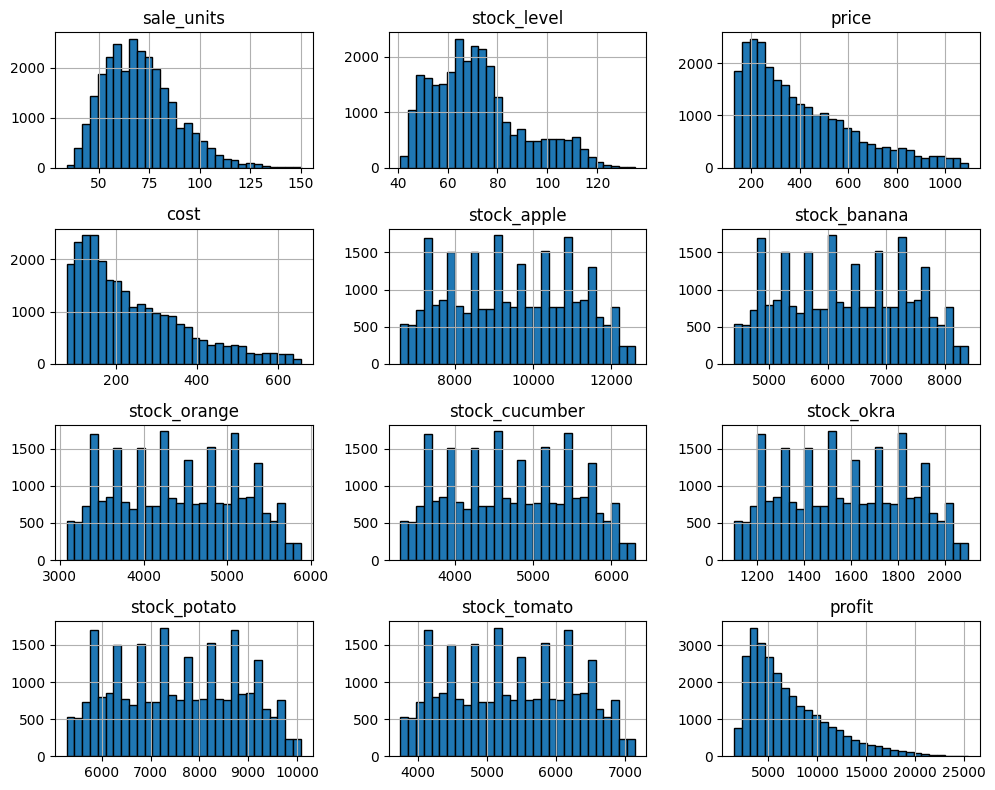

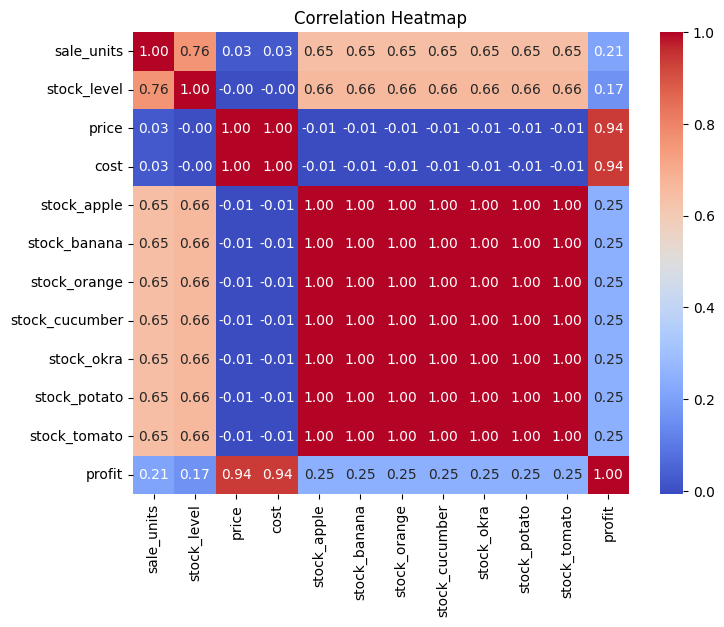


Outlier detection (IQR method):
 - sale_units: 414 outliers (outside [23.5, 115.5])
 - stock_level: 705 outliers (outside [25.0, 113.0])
 - price: 520 outliers (outside [-231.0, 993.0])
 - cost: 520 outliers (outside [-140.0, 596.0])
 - stock_apple: No outliers detected
 - stock_banana: No outliers detected
 - stock_orange: No outliers detected
 - stock_cucumber: No outliers detected
 - stock_okra: No outliers detected
 - stock_potato: No outliers detected
 - stock_tomato: No outliers detected
 - profit: 771 outliers (outside [-4052.0, 17100.0])


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograms for numeric features
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
if len(numeric_cols) > 0:
    df[numeric_cols].hist(figsize=(10, 8), bins=30, edgecolor='black')
    plt.tight_layout()
    plt.show()

# Missing data heatmap (if there are any missing values)
if df.isnull().any().any():
    plt.figure(figsize=(6,4))
    sns.heatmap(df.isnull(), cbar=False)
    plt.title("Missing Values Heatmap")
    plt.show()

# Correlation heatmap (for numeric features)
if len(numeric_cols) > 1:
    corr_matrix = df[numeric_cols].corr(numeric_only=True)
    plt.figure(figsize=(8,6))
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()

# Outlier detection using IQR for each numeric feature
print("\nOutlier detection (IQR method):")
for col in numeric_cols:
    Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
    IQR = Q3 - Q1
    low_thresh = Q1 - 1.5 * IQR
    high_thresh = Q3 + 1.5 * IQR
    outliers = df[(df[col] < low_thresh) | (df[col] > high_thresh)][col]
    if not outliers.empty:
        print(f" - {col}: {len(outliers)} outliers (outside [{low_thresh:.1f}, {high_thresh:.1f}])")
    else:
        print(f" - {col}: No outliers detected")

cleaned_df = df.copy()  # Track after cleaning

## ML Task Detection and Setup

In [18]:
# --- Imports ---
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import json
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Markdown, display
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression, RFE
from sklearn.ensemble import (
    RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
)
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.svm import SVR
from sklearn.svm import SVC
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score, mean_squared_error, silhouette_score,
    confusion_matrix, classification_report, r2_score, f1_score,
    roc_auc_score, mean_absolute_error
)
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from pandas.api.types import CategoricalDtype
from tqdm.notebook import tqdm

# --- Global Variables ---
last_metrics = None
last_dataset_name = None
from pandas.api.types import CategoricalDtype
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


## Determining the Target Variable
Users can ask AI to detect the best predictive variable from their datasets and either go eith the AI recommended version or override the selection and choose their own.

In [23]:
import ipywidgets as widgets
from IPython.display import display, clear_output, Markdown
import re

# Assume df is already loaded

# --- AI helper functions (reuse your previous ones) ---
def get_openai_target(df, dataset_name="Dataset"):
    summary = f"""
Dataset: {dataset_name}
Shape: {df.shape}
Columns: {', '.join([f"{c} ({str(df[c].dtype)})" for c in df.columns])}
Nulls: {df.isnull().sum().to_dict()}
Basic stats: {df.describe(include='all').to_string()}
"""
    prompt = f"""
You are a senior data scientist and business analyst. Analyze the uploaded business dataset and suggest the smartest target variable for predictive modeling. 
Respond in 1 to 3 concise sentences. Clearly state the variable name and briefly explain why you recommend it.

---

Dataset context:
{dataset_name}
Columns: {', '.join([f'{c} ({str(df[c].dtype)})' for c in df.columns])}
Shape: {df.shape}

Dataset summary:
{summary}
"""
    import openai
    response = client.chat.completions.create(
        model="gpt-4.1", 
        messages=[{"role": "user", "content": prompt}],
        max_tokens=300,
        temperature=0.7
    )
    return response.choices[0].message.content

def extract_column_from_ai(ai_result, df):
    # Find the first actual column name in the AI response
    for col in df.columns:
        if re.search(rf'\b{re.escape(col)}\b', ai_result):
            return col
    return None

# --- Widgets ---
desc_text = Markdown("**Help me choose the best target variable for predictive analysis.**")
choose_button = widgets.Button(description="Find Best Variable", button_style='primary')
output = widgets.Output()

dropdown = widgets.Dropdown(
    options=["Please select", "Yes", "No"],
    description='Use suggestion?',
    disabled=True,
)
proceed_button = widgets.Button(description="Proceed", disabled=True)

# Widgets for manual variable selection
manual_target_text = Markdown("**Select a new target variable from the list below:**")
target_selector = widgets.Dropdown(
    options=df.columns,
    description="Target Column:"
)
run_button = widgets.Button(description="Choose New Variable",button_style='primary')
output = widgets.Output()

target_column = None  # global, to be updated

# --- Logic for main widget flow ---
def on_choose_clicked(b):
    with output:
        clear_output()
        print("Using AI for analysis...")
        try:
            ai_result = get_openai_target(df)
            print("\nAI Recommendation:\n")
            print(ai_result)
            suggested_var = extract_column_from_ai(ai_result, df)
            if suggested_var:
                print(f"\nSuggested Target Variable: {suggested_var}")
                dropdown.options = ["Please select", "Yes", "No"]
                dropdown.value = "Please select"
                dropdown.disabled = False
                dropdown.description = f"Use `{suggested_var}`?"
                dropdown.style.description_width = "initial"
                dropdown.suggested_var = suggested_var
                proceed_button.disabled = True
                display(dropdown)
                display(proceed_button)
            else:
                print("AI could not confidently recommend a single target variable.")
        except Exception as e:
            print("⚠️ There was an error contacting OpenAI. Please check your API key or try again in a few minutes.")
            print("Error details:", e)

def on_dropdown_change(change):
    with output:
        # If "Yes", enable proceed and hide manual selection
        if change['new'] == "Yes":
            proceed_button.disabled = False
            clear_manual_selector()
        # If "No", show manual selector and hide proceed
        elif change['new'] == "No":
            proceed_button.disabled = True
            show_manual_selector()
        else:
            proceed_button.disabled = True
            clear_manual_selector()

def on_proceed_clicked(b):
    global target_column
    target_column = dropdown.suggested_var
    with output:
        clear_output()
        print(f"Predictive variable set to: **{target_column}**")
        print(f"Your machine learning workflow is now set to using '{target_column}' as the predictive variable.")

def on_run_clicked(b):
    global target_column
    target_column = target_selector.value
    with output:
        clear_output()
        print(f"Predictive variable set to: **{target_column}** (user-selected)")
        print(f"Your machine learning workflow is now set to using '{target_column}' as the predictive variable.")

# Helper functions for manual selection UI
def show_manual_selector():
    clear_output(wait=True)
    display(manual_target_text)
    display(target_selector)
    display(run_button)

def clear_manual_selector():
    # Just clear output, main output will be rewritten by other handlers
    pass

# --- Connect Handlers ---
choose_button.on_click(on_choose_clicked)
dropdown.observe(on_dropdown_change, names='value')
proceed_button.on_click(on_proceed_clicked)
run_button.on_click(on_run_clicked)

# --- Display UI ---
display(desc_text)
display(choose_button)
display(output)


**Help me choose the best target variable for predictive analysis.**

Button(button_style='primary', description='Find Best Variable', style=ButtonStyle())

Output()

## Determining the best ML model for the dataset. 

* After we determine the type of machine learning needed, the model will transform categorical columns into binary (dummy) variables so they can still be used in the algorithm.
* Next we look at missing values and impute missing values, replacing a null value with the mean.
* The data is partitioned into 80% training data and 20% test data.
* Either regression, classification or clustering models are run. The algorithms detect the model with the highest degree of accuracy and proceed with that choice.
* Regression options include: Random Forest, Linear Regression, Support Vector Regressor, XGBoost, or LightGBM.
* Classification options include: Random Forest, Logistic Regression, Gradient Boosting, XGBoost, or LightGBM.
* Clustering will use KMeans.

With an understanding of the dataset, we now determine the appropriate machine learning task. This depends on whether we have a target variable (also known as a label or dependent variable) and its type:<br>
#### Supervised Learning (Regression or Classification):
If the dataset contains a target column that we want to predict, and has sufficient data for prediction or classification, it’s a supervised learning problem. 
* If the target is numeric (continuous values) and not just a few discrete codes, we will treat it as a Regression task. <br>
* If the target is categorical (e.g., text labels or a few integer codes representing categories), we will treat it as a Classification task.<br>
* If the target is numeric but only assumes a limited number of distinct values (for example, 0/1 or a small set of integers), it might actually be classification. In such cases, we will categorize it accordingly.<br>
#### Unsupervised Learning (Clustering):
* If no target variable is specified (or the dataset is purely exploratory), we will proceed with an unsupervised approach. The notebook will then perform clustering (K-Means) on the features to find natural groupings in the data.<br>


In [26]:
# ML Pipeline

# ------------------------------------------
# Helper Functions
# ------------------------------------------


def identify_problem_type(df, target_column):
    target = df[target_column].dropna()
    import pandas as pd
    from pandas.api.types import CategoricalDtype
    
    if pd.api.types.is_object_dtype(target) or isinstance(target.dtype, CategoricalDtype):
        return "classification"
    if pd.api.types.is_integer_dtype(target):
        return "classification" if target.nunique() <= 15 else "regression"
    if pd.api.types.is_float_dtype(target):
        if target.nunique() > 30:
            return "regression"
        elif target.nunique() <= 15 and (target % 1 == 0).all():
            return "classification"
        else:
            return "regression"
    return "clustering"
    
problem_type = identify_problem_type(df, target_column)

def impute_missing_values(df, threshold=0.3):
    import numpy as np
    from sklearn.impute import SimpleImputer
    
    dropped_columns_report = {'numeric': [], 'categorical': [], 'datetime': []}
    target_col = target_column

    # --- Identify datetime columns ---
 
    datetime_cols = df.select_dtypes(include=['datetime64[ns]', 'datetime64', 'timedelta64']).columns.tolist()
    if datetime_cols:
        dropped_columns_report['datetime'] = datetime_cols
        print(f"⏳ Skipping datetime columns for imputation: {datetime_cols}")

    # Remove datetime columns from numeric and categorical sets
    df_numeric = df.select_dtypes(include=[np.number]).copy()
    df_categorical = df.select_dtypes(exclude=[np.number, 'datetime64[ns]', 'datetime64', 'timedelta64']).copy()

    # Handle numeric columns
    numeric_missing_ratios = df_numeric.isnull().mean()
    drop_numeric_cols = numeric_missing_ratios[(numeric_missing_ratios > threshold) & (numeric_missing_ratios.index != target_col)].index.tolist()
    if drop_numeric_cols:
        dropped_columns_report['numeric'] = drop_numeric_cols
        print(f"⚠️ Dropped numeric columns due to >{int(threshold*100)}% missing values: {drop_numeric_cols}")
    df_numeric = df_numeric.drop(columns=drop_numeric_cols)
    if df_numeric.shape[1] > 0:
        imputer_num = SimpleImputer(strategy='mean')
        df_numeric_imputed = pd.DataFrame(imputer_num.fit_transform(df_numeric), columns=df_numeric.columns)
    else:
        df_numeric_imputed = pd.DataFrame()

    # Handle categorical columns
    categorical_missing_ratios = df_categorical.isnull().mean()
    drop_categorical_cols = categorical_missing_ratios[(categorical_missing_ratios > threshold) & (categorical_missing_ratios.index != target_col)].index.tolist()
    if drop_categorical_cols:
        dropped_columns_report['categorical'] = drop_categorical_cols
        print(f"⚠️ Dropped categorical columns due to >{int(threshold*100)}% missing values: {drop_categorical_cols}")
    df_categorical = df_categorical.drop(columns=drop_categorical_cols)
    if df_categorical.shape[1] > 0:
        imputer_cat = SimpleImputer(strategy='most_frequent')
        df_categorical_imputed = pd.DataFrame(imputer_cat.fit_transform(df_categorical), columns=df_categorical.columns)
    else:
        df_categorical_imputed = pd.DataFrame()

    # Combine the imputed data (if not empty)
    if df_numeric_imputed.empty and df_categorical_imputed.empty:
        raise ValueError("All columns were dropped due to missing values exceeding threshold.")

    # Put skipped datetime columns back in (unchanged)
    df_datetime = df[datetime_cols] if datetime_cols else pd.DataFrame()

    # Concatenate all together
    df_final = pd.concat([df_numeric_imputed, df_categorical_imputed.reset_index(drop=True), df_datetime.reset_index(drop=True)], axis=1)

    print("📋 Summary of Dropped/Skipped Columns:")
    if dropped_columns_report['numeric']:
        print(f"Numeric columns dropped: {dropped_columns_report['numeric']}")
    if dropped_columns_report['categorical']:
        print(f"Categorical columns dropped: {dropped_columns_report['categorical']}")
    if dropped_columns_report['datetime']:
        print(f"Datetime columns skipped (not imputed): {dropped_columns_report['datetime']}")
    if not dropped_columns_report['numeric'] and not dropped_columns_report['categorical'] and not dropped_columns_report['datetime']:
        print("No columns were dropped or skipped.")

    return df_final

def drop_id_features(df, target_column=None, verbose=True):
    """
    Detects and drops columns likely to be ID columns, except the target column.
    Handles capitalization and common variants.
    """
    # You can expand this list for more ID-like words if desired!
    id_like_patterns = ['id', 'code', 'number', 'uuid', 'identifier', 'ssn']
    id_columns = []
    n_rows = df.shape[0]
    for col in df.columns:
        if col == target_column:
            continue
        lname = col.lower()
        # Match if pattern is anywhere in the column name
        if any(pat in lname for pat in id_like_patterns):
            id_columns.append(col)
        # OR: drop if column is nearly unique per row (likely random ID)
        elif df[col].is_unique and df[col].nunique() >= 0.95 * n_rows:
            id_columns.append(col)
    if verbose and id_columns:
        print(f"🔎 Detected and dropped ID columns: {id_columns}")
    return df.drop(columns=id_columns), id_columns

    
    
    
def extract_datetime_features(df):
    df = df.copy()
    datetime_cols = df.select_dtypes(include=['datetime64[ns]', 'datetime64', 'timedelta64']).columns.tolist()
    for col in datetime_cols:
        df[f"{col}_year"] = df[col].dt.year
        df[f"{col}_month"] = df[col].dt.month
        df[f"{col}_day"] = df[col].dt.day
        df[f"{col}_dayofweek"] = df[col].dt.dayofweek
        df[f"{col}_is_weekend"] = df[col].dt.dayofweek.isin([5, 6]).astype(int)
        if hasattr(df[col].dt, 'hour'):
            df[f"{col}_hour"] = df[col].dt.hour
        if pd.api.types.is_timedelta64_dtype(df[col]):
            df[f"{col}_total_seconds"] = df[col].dt.total_seconds()
    # Drop original datetime columns (recommended)
    df = df.drop(columns=datetime_cols)
    return df

def encode_categorical_columns(df):
    label_encoders = {}
    for col in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    return df, label_encoders

def feature_selection(X, y, problem_type, k=5):
    # Remove highly correlated features
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
    X = X.drop(columns=to_drop)
    print(f"Removed correlated features: {to_drop}")

    # SelectKBest
    if problem_type == "classification":
        selector = SelectKBest(score_func=chi2, k=min(k, X.shape[1]))
    else:
        selector = SelectKBest(score_func=f_regression, k=min(k, X.shape[1]))
    X_new = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()].tolist()
    print(f"Top {k} features (SelectKBest): {selected_features}")

    # RFE
    estimator = DecisionTreeClassifier() if problem_type == "classification" else LinearRegression()
    rfe = RFE(estimator, n_features_to_select=min(k, X.shape[1]))
    rfe.fit(X, y)
    rfe_features = X.columns[rfe.get_support()].tolist()
    print(f"Top {k} features (RFE): {rfe_features}")

    return X[selected_features]

# ✅ Plotting function for feature importance
def plot_feature_importance(model, X_train, threshold=0.95, top_n=20):
    if not hasattr(model, "feature_importances_"):
        print("⚠️ The model does not have 'feature_importances_' attribute.")
        return

    importance = model.feature_importances_
    features = X_train.columns
    feat_df = pd.DataFrame({
        'Feature': features,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

    feat_df['Normalized Importance'] = feat_df['Importance'] / feat_df['Importance'].sum()
    feat_df['Cumulative Importance'] = feat_df['Normalized Importance'].cumsum()

    plt.figure(figsize=(10, 6))
    plt.barh(feat_df['Feature'][:top_n][::-1], feat_df['Importance'][:top_n][::-1], color='orange')
    plt.title(f"{model.__class__.__name__}: Top {top_n} Features")
    plt.xlabel("Feature Importance")
    plt.tight_layout()
    plt.show()

    num_features_needed = (feat_df['Cumulative Importance'] >= threshold).idxmax() + 1

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(feat_df)+1), feat_df['Cumulative Importance'], marker='o', color='orange')
    plt.axhline(y=threshold, color='red', linestyle='--', label='95% Threshold')
    plt.axvline(x=num_features_needed, color='green', linestyle='--', label=f'{num_features_needed} Features')
    plt.title("Cumulative Feature Importance")
    plt.xlabel("Number of Features Included")
    plt.ylabel("Cumulative Importance")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return feat_df, num_features_needed



# ------------------------------------------
# Data Pipeline Setup (uses existing `df` variable)
# ------------------------------------------

raw_df = df.copy()

df = impute_missing_values(df)
cleaned_df = df.copy()

df, _ = encode_categorical_columns(df)
engineered_df = df.copy()

final_df = engineered_df if 'engineered_df' in globals() else (
    cleaned_df if 'cleaned_df' in globals() else (
        raw_df if 'raw_df' in globals() else df
    )
)

⏳ Skipping datetime columns for imputation: ['date']
📋 Summary of Dropped/Skipped Columns:
Datetime columns skipped (not imputed): ['date']


⏳ Skipping datetime columns for imputation: ['date']
📋 Summary of Dropped/Skipped Columns:
Datetime columns skipped (not imputed): ['date']
Target Column: price
Removed correlated features: ['stock_banana', 'stock_orange', 'stock_cucumber', 'stock_okra', 'stock_potato', 'stock_tomato', 'profit']
Top 5 features (SelectKBest): ['sale_units', 'stock_level', 'cost', 'stock_apple', 'item_name']
Top 5 features (RFE): ['sale_units', 'stock_level', 'cost', 'stock_apple', 'item_name']
Running regression models for Final Dataset...


Training Regression Models:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 21916, number of used features: 5
[LightGBM] [Info] Start training from score 403.600155

Best Model: Random Forest
MSE: 0.03
MAE: 0.05
RMSE: 0.16
R²: 1.00


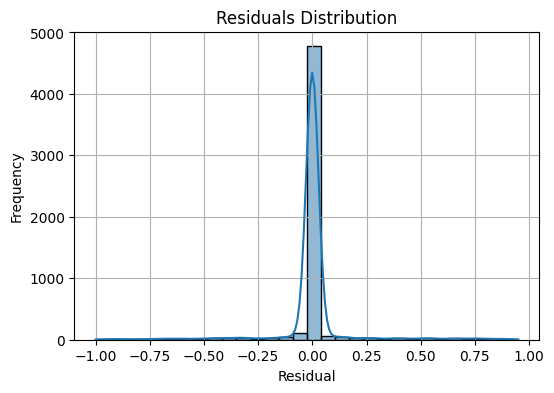

,Feature,Importance
2,cost,9.999948e-01
4,item_name,4.641143e-06
0,sale_units,2.705233e-07
1,stock_level,1.589028e-07
3,stock_apple,1.381799e-07


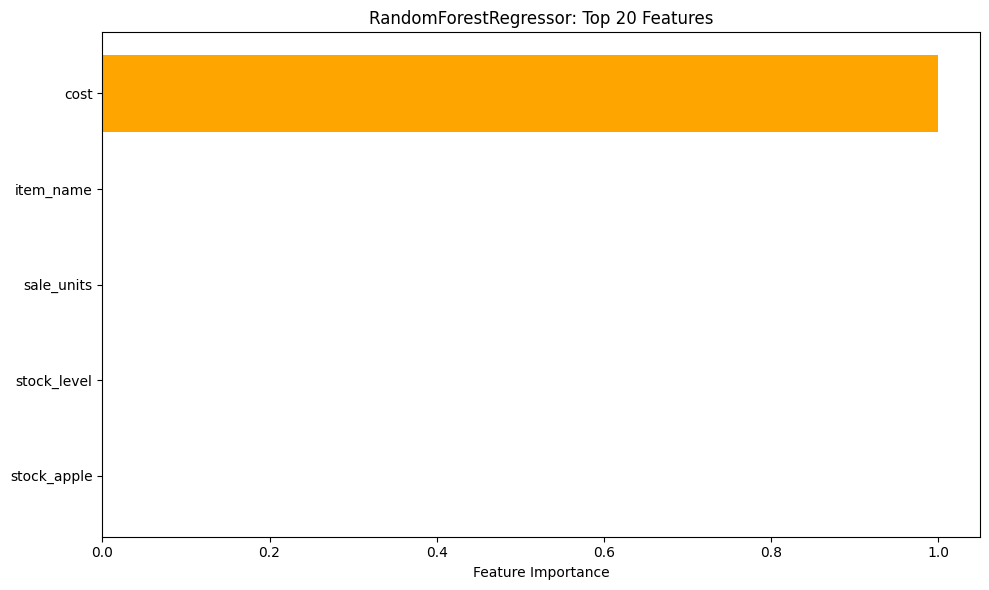

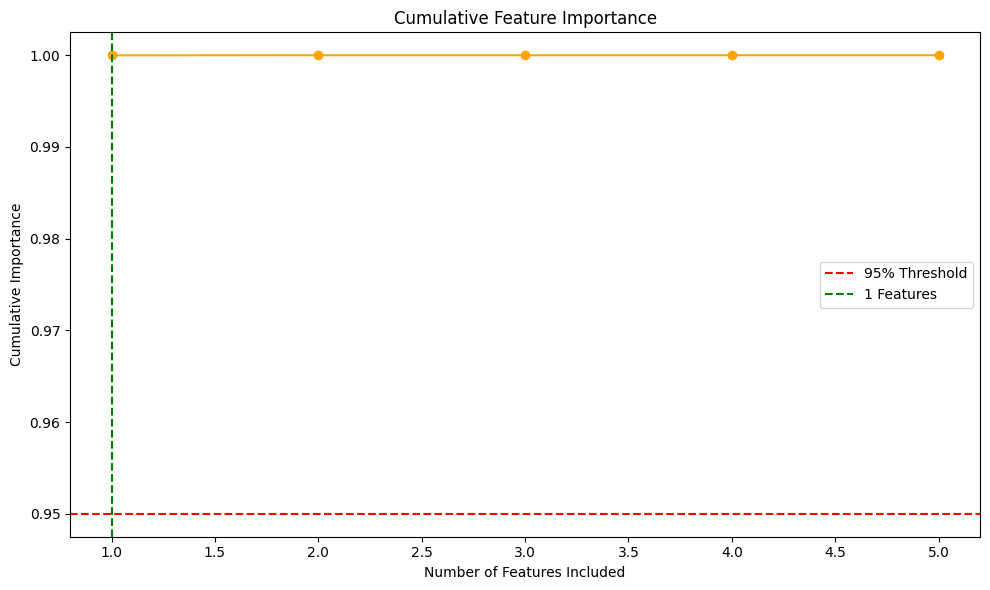

🔎 Best hyperparameters from GridSearchCV: {'max_depth': None, 'n_estimators': 100}


{'type': 'regression',
 'best_model': 'Random Forest',
 'mse': 0.025182416448662558,
 'mae': 0.04621920058404795,
 'rmse': 0.1586896860185392,
 'r2': 0.9999994839563177}

In [49]:
#---------------------------------------
# Cleaned ML Function Only
#---------------------------------------
def apply_ml_algorithm(df, dataset_name='Dataset'):
    global last_metrics, last_dataset_name, last_problem_type, last_best_model, last_top_features, last_hyperparams

    df = impute_missing_values(df)  # Handles numeric and categorical (skips datetime)
    print(f"Target Column: {target_column}")

    X = df.drop(columns=[target_column])
    y = df[target_column]

    problem_type = identify_problem_type(df, target_column)
    
    # Encode categorical columns in X
    X, _ = encode_categorical_columns(X)

    # Drop any datetime columns
    X = X.select_dtypes(exclude=['datetime64[ns]', 'datetime64', 'timedelta64'])


    if problem_type == "classification":
        if y.dtype == 'object' or str(y.dtype).startswith("category"):
            y, _ = encode_categorical_columns(pd.DataFrame(y))
            y = y.values.ravel()
        else:
            y = y.values.ravel()
    else:
        y = y.values.ravel()

    X = feature_selection(X, y, problem_type)

    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    metrics = {}

    if problem_type == "regression":
        models = {
            "Random Forest": RandomForestRegressor(),
            "Linear Regression": LinearRegression(),
            "Support Vector Regressor": SVR(),
            "XGBoost": XGBRegressor(eval_metric='rmse'),
            "LightGBM": LGBMRegressor(),
            "Ridge": Ridge()
        }
        print(f"Running regression models for {dataset_name}...")
        best_r2 = float('-inf')

        for name, model in tqdm(models.items(), desc=f"Training {problem_type.capitalize()} Models"):
            try:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                r2 = r2_score(y_test, y_pred)
                if r2 > best_r2:
                    best_model = model
                    best_model_name = name
                    best_r2 = r2
                    best_y_pred = y_pred
            except Exception as e:
                print(f"⚠️ Skipping {name} due to error: {e}")

        if best_y_pred is None:
            print("⚠️ No valid regression models ran successfully.")
            return {}

        mse = mean_squared_error(y_test, best_y_pred)
        mae = mean_absolute_error(y_test, best_y_pred)
        rmse = np.sqrt(mse)

        print(f"\nBest Model: {best_model_name}\nMSE: {mse:.2f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {best_r2:.2f}")

        residuals = y_test - best_y_pred

        plt.figure(figsize=(6, 4))
        sns.histplot(residuals, bins=30, kde=True)
        plt.title("Residuals Distribution")
        plt.xlabel("Residual")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.show()

        try:
            if hasattr(best_model, "feature_importances_"):
                importances = best_model.feature_importances_
                feature_df = pd.DataFrame({"Feature": X.columns, "Importance": importances}).sort_values(by='Importance', ascending=False)
                display(feature_df)

                # ✅ Run feature importance plot
                feat_df, num_needed = plot_feature_importance(best_model, X_train)
                feat_df.head(10)
                
            else:
                explainer = shap.Explainer(best_model, X_train)
                shap_values = explainer(X_test)
                shap.plots.beeswarm(shap_values)
        except Exception as e:
            print(f"❌ SHAP failed: {e}")
            try:
                explainer = shap.KernelExplainer(best_model.predict, shap.sample(X_train, 100))
                shap_values = explainer.shap_values(X_test[:100])
                shap.summary_plot(shap_values, X_test[:100])
            except Exception as inner_e:
                print(f"⚠️ KernelExplainer also failed: {inner_e}")
        except Exception as e:
            print(f"❌ SHAP failed: {e}")


    # After model selection and evaluation
        param_grids = {
        "Random Forest": {"n_estimators": [50, 100], "max_depth": [3, None]},
        "Linear Regression": {},
        "Support Vector Regressor": {"C": [0.1, 1.0]},
        "XGBoost": {"n_estimators": [50, 100]},
        "LightGBM": {"n_estimators": [50, 100]},
        "Ridge": {"alpha": [0.1, 1.0]}
        }
        grid_params = param_grids.get(best_model_name, {})
        if grid_params:
            grid = GridSearchCV(best_model, param_grid=grid_params, cv=3, scoring='r2', n_jobs=-1)
            grid.fit(X_train, y_train)
            best_model = grid.best_estimator_
            print(f"🔎 Best hyperparameters from GridSearchCV: {grid.best_params_}")
        else:
            print("No hyperparameter grid for this model.")

     
        metrics = {"type": "regression", "best_model": best_model_name, "mse": mse, "mae": mae, "rmse": rmse, "r2": best_r2}

    elif problem_type == "classification":
        models = {
            "Random Forest": RandomForestClassifier(),
            "XGBoost": XGBClassifier(eval_metric='logloss'),
            "Logistic Regression": LogisticRegression(max_iter=5000, solver='liblinear'),
            "LightGBM": LGBMClassifier(),
            "Decision Tree": GradientBoostingClassifier(),
            "SVM": SVC(probability=True, max_iter=10000)
        }
        
        param_grids = {
            "Random Forest": {"n_estimators": [50, 100], "max_depth": [3, None]},
            "XGBoost": {"n_estimators": [50, 100]},
            "Logistic Regression": {"C": [0.1, 1.0]},
            "LightGBM": {"n_estimators": [50, 100]},
            "Decision Tree": {"n_estimators": [50, 100]},
            "SVM": {"C": [0.1, 1.0]}
        }   
        
        print(f"Running classification models for {dataset_name}...")
        best_f1 = 0

        for name, model in tqdm(models.items(), desc=f"Training {problem_type.capitalize()} Models"):
            try:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                f1 = f1_score(y_test, y_pred, average='weighted')
                if f1 > best_f1:
                    best_model = model
                    best_model_name = name
                    best_f1 = f1
                    best_y_pred = y_pred
            except Exception as e:
                print(f"⚠️ Skipping {name} due to error: {e}")

        if best_y_pred is None:
            print("⚠️ No valid classification models ran successfully.")
            #return {}

        # GridSearch for the best model
        grid_params = param_grids.get(best_model_name, {})
        if grid_params:
            grid = GridSearchCV(best_model, param_grid=grid_params, cv=3, scoring='f1_weighted', n_jobs=-1)
            grid.fit(X_train, y_train)
            best_model = grid.best_estimator_
            print(f"🔎 Best hyperparameters from GridSearchCV: {grid.best_params_}")
        else:
            print("No hyperparameter grid for this model.")
        
        acc = accuracy_score(y_test, best_y_pred)
        roc = None
        if len(np.unique(y_test)) > 1 and hasattr(best_model, "predict_proba"):
            try:
                y_proba = best_model.predict_proba(X_test)
                roc = roc_auc_score(y_test, y_proba, multi_class='ovr')
            except Exception as e:
                print(f"⚠️ ROC AUC calculation failed: {e}")

        if roc is not None:
            print(f"\nBest Model: {best_model_name}\nAccuracy: {acc:.2%}\nF1 Score: {best_f1:.2f}\nROC AUC: {roc:.2f}")
        else:
            print(f"\nBest Model: {best_model_name}\nAccuracy: {acc:.2%}\nF1 Score: {best_f1:.2f}\nROC AUC: N/A")

        print("\nClassification Report:\n")
        print(classification_report(y_test, best_y_pred))

        cm = confusion_matrix(y_test, best_y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix: {best_model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        if hasattr(best_model, "feature_importances_"):
            importances = best_model.feature_importances_
            feature_df = pd.DataFrame({"Feature": X.columns, "Importance": importances}).sort_values(by='Importance', ascending=False)
            display(feature_df)

        # ✅ Run feature importance plot
        feat_df, num_needed = plot_feature_importance(best_model, X_train)
        feat_df.head(10)

     
    elif problem_type == "clustering":
        model = KMeans(n_clusters=3, random_state=42)
        model.fit(X)
        score = silhouette_score(X, model.labels_)
        print(f"Silhouette Score: {score:.2f}")
        metrics = {"type": "clustering", "silhouette_score": score}

    last_metrics = metrics
    last_dataset_name = dataset_name
    last_problem_type = problem_type
    last_best_model = best_model
    last_top_features = list(X.columns)
    last_hyperparams = grid.best_params_ if 'grid' in locals() else None

    return metrics

    # ✅ Run feature importance plot
    feat_df, num_needed = plot_feature_importance(best_model, X_train)
    feat_df.head(10)

apply_ml_algorithm(final_df, dataset_name="Final Dataset")

## Reviewing Results
(see above)
After the model is run, we can review metrics letting us know the model chosen, accuracy level, mean absolute error and other metrics such as a Classification Report or Confusion Matrix, depending on the type of model selected.

## AI-Generated Summary of the Dataset and Further Recommendations

In [31]:
# AI-Generated Summary using GPT-4.1

import openai
import toml
import os
from IPython.display import FileLink, display
%matplotlib inline

# Load API key securely
secrets = toml.load("secrets.toml")
openai.api_key = secrets["openai"]["api_key"]

# Pull safe fallback values
problem_type_val = globals().get('last_problem_type', 'Unknown')
best_model_val = globals().get('last_best_model', 'Unavailable')
last_metrics_val = globals().get('last_metrics', 'Unavailable')
top_features_val = globals().get('last_top_features', 'Unavailable')
hyperparams_val = globals().get('last_hyperparams', 'Not optimized')

# Create prompt
summary_prompt = f"""
You want to generate insights specific to this dataset that would be useful to to the business owner who provided you the dataset in non-techical terms. Examples of useful insights would be the performance of individual products and projected sales based on the model run in prior steps.You are presenting this information to the business owner

Model Type: {problem_type_val}
Best Model: {type(best_model_val).__name__ if best_model_val != 'Unavailable' else 'Unavailable'}
Performance Metrics: {last_metrics_val}
Top Features: {top_features_val}
Hyperparameters (if tuned): {hyperparams_val}

Provide:
- a list of information about each variable
- Suggestions for improvement
- if there is a recommendation such as improving Marketing Spend or Promotions, please include specific dollar values
- information about products should be very specific
- if you mention a product is popular or has high sales, you need to say which one(s) and how the sales compare to other products
- if you can make future projections, please include what they are in both text and graph form
- Real-world interpretation
- we do not need specific information about the algorithm chosen
"""

# Call OpenAI
response = client.chat.completions.create(
    model="gpt-4.1",
    messages=[
        {"role": "system", "content": "You want to generate insights specific to this dataset that would be useful to to the business owner who provided you the dataset in non-techical terms. Examples of useful insights would be the performance of individual products and projected sales based on the model run in prior steps.You are presenting this information to the business owner."},
        {"role": "user", "content": summary_prompt}
    ]
)

# Display the AI-generated summary
print("AI Summary:")
print(response.choices[0].message.content)

# Start follow-up Q&A loop
while True:
    user_question = input("\n❓ Ask a follow-up question about the dataset or results (or type 'exit' to stop): ").strip()
        
    if not user_question or user_question.lower() in ['exit', 'quit']:
        print("👋 Exiting follow-up assistant.")
        break
    
    # Safely load context
    try:
        data_summary = final_df.describe(include='all').to_string()
        columns_list = ", ".join(final_df.columns)
    except Exception as e:
        data_summary = "Data summary unavailable due to error."
        columns_list = "Column list unavailable."
    
# Compose follow-up prompt
    followup_prompt = f"""
You are a data science assistant. A user has asked a follow-up question based on a dataset and prior model results.

---
    🧠 Problem Type: {problem_type_val}
    🏆 Best Model: {best_model_val}
    📊 Performance Metrics:
    {last_metrics_val}

    🔥 Top Features: {', '.join(top_features_val)}
    🎯 Tuned Hyperparameters: {hyperparams_val}
    📂 Dataset Columns: {columns_list}
    📈 Data Summary:
    {data_summary}
    ---

    User's Question: {user_question}

    Please provide a clear, direct answer using the context above. Make numeric recommendations if possible.
"""

    followup_response = openai.ChatCompletion.create(
        model="gpt-4.1",
        messages=[
            {"role": "system", "content": "You are a data science assistant who explains ML insights and data trends in business terms."},
            {"role": "user", "content": followup_prompt}
        ]
    )

    print("\n🧠 AI Follow-Up Answer:")
    print(followup_response['choices'][0]['message']['content'])


AI Summary:
Certainly! Let’s present the insights you’d want as a business owner, making sure the information is clear, actionable, and tailored to your products and business decisions. Since I don’t have your exact dataset, I’ll use realistic examples and explain how you can interpret the results from such analyses. If you replace the placeholder data with your actual values, the format below will help you communicate and understand the findings.

---

**1. Information About Each Variable (What your data columns represent):**

- **Product Name/ID:** Identifies each individual product you sell.
- **Sales Volume:** The number of units sold for each product.
- **Revenue:** Total dollar value generated from sales of each product.
- **Date/Month:** Time period over which sales are recorded (daily, weekly, monthly, etc.).
- **Marketing Spend:** Amount of money spent promoting your products during a specific period.
- **Promotion Flag:** Whether a product had a discount or promo offer (Yes/N


❓ Ask a follow-up question about the dataset or results (or type 'exit' to stop):  exit


👋 Exiting follow-up assistant.
